Author: Juana Karina Diaz Barba

### Step 1: getting and transforming the data

In [1]:
import pandas as pd
import yaml
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import IsolationForest

from joblib import dump, load
import matplotlib.pyplot as plt


In [21]:
def get_config():
    '''Setting the config file'''
    with open('config_prog2.yaml', 'r') as stream:
        config = yaml.safe_load(stream)
        return config

config = get_config()
sensor_path = (config['sensor'])

# Creating a data frame with the data
data_df = pd.read_csv(sensor_path)
print(data_df.shape)
data_df.head(3)


(220320, 55)


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


In [22]:
# Dropping non needed and low quality columns
# 'sensor_15' and 'sensor_50' have a lot of missing data values compared with 
# the other sensors
data_df.drop(['Unnamed: 0','sensor_15', 'sensor_50'], axis=1, inplace=True)
# Convert timestamp to datetime and set it as index
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
data_df.set_index('timestamp', inplace=True)

In [24]:
data_df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


We're going to **train** the model on the months **April, May, and June** and then use the trained model to **predict** the anomalies of the months **July and August**. 

In [30]:
train_data = data_df.loc[(data_df.index >= '2018-04-01')
                     & (data_df.index < '2018-06-30')]

july_data = data_df.loc[(data_df.index >= '2018-07-01')
                     & (data_df.index < '2018-07-31')]

august_data = data_df.loc[(data_df.index >= '2018-08-01')
                     & (data_df.index < '2018-08-31')]

print(f'Train data size: {train_data.shape}')
print(f'July data size: {july_data.shape}')
print(f'August data size: {august_data.shape}')
# # Create files of the data split
# train_data.to_csv('Week2.7_sensor_train_data.csv')
# train_data.to_csv('Week2.7_sensor_july_data.csv')
# train_data.to_csv('Week2.7_sensor_august_data.csv')


Train data size: (129600, 51)
July data size: (43200, 51)
August data size: (43200, 51)


### Step 2: create the model and the drawer

In [31]:
# Divide the data
def sensor_status(data_df):
    '''Divide the sensor data based on its machine status'''
    broken_rows = data_df[data_df['machine_status']=='BROKEN']
    recovery_rows = data_df[data_df['machine_status']=='RECOVERING']
    normal_rows = data_df[data_df['machine_status']=='NORMAL']
    return  broken_rows, recovery_rows, normal_rows

def calculate_outliers_fraction(normal_rows, data_df):
    '''To calculate the fraction of outliers on the dataset'''
    outliers_fraction = 1 - (len(normal_rows)/(len(data_df)))
    return outliers_fraction

In [32]:
# Preprocessing
def data_imputation(data_df):
    '''Function to imputate the missing values in the data frame'''
    # Use mean of the column to handle missing values and remove label in feature matrix X
    m, n = data_df.shape
    # Ignore machine status columns (last column in the dataframe)
    X = data_df.iloc[:,:n-1] 
    X = X.fillna(X.mean())
    # Matrix with the data
    print(X.shape)
    return X

def data_scaling(data_df):
    '''Function to scale the data'''
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler()
    # Fit to data, then transform it.
    X = scaler.fit_transform(data_df)
    return X

In [33]:

train_broken_rows, train_recovery_rows, train_normal_rows = sensor_status(train_data)
outliers_fraction = calculate_outliers_fraction(train_normal_rows, train_data)

In [34]:
X_train = data_imputation(train_data)
X_train = data_scaling(X_train)


(129600, 50)


In [9]:
# anomaly_algorithms = [
#     ("Isolation Forest",IsolationForest(contamination=outliers_fraction,
#                                         n_jobs = -1)),
#     ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction))]
# def train_models(X, anomaly_algorithms):
#     for name, algorithm in anomaly_algorithms:
#         print(algorithm)
#         y_pred = algorithm.fit(X).predict(X)
#         train_data[f'{name}'] = y_pred
#         print('-'*100)
#         print(f'Number of anomalies detected')
#         print(train_data[f'{name}'].value_counts())
#         print('-'*100)
    
# #     return name, y_pred
# train_models(X_train, anomaly_algorithms)

In [35]:
# 3m  53 sesin
# Training One-Class SVM for unsupervised Outlier Detection.
def svm_train(outliers_fraction, X):
    clf = svm.OneClassSVM(nu=outliers_fraction)
    y_pred = clf.fit(X).predict(X)
    print('OneClassSVM')
    print('-'*100)
    train_data['svc'] = y_pred
    print(f'Number of anomalies detected')
    print(train_data['svc'].value_counts())
    return clf, y_pred

classifier_svm, y_pred = svm_train(outliers_fraction, X_train)
print(y_pred)
classifier_svm

OneClassSVM
----------------------------------------------------------------------------------------------------
Number of anomalies detected
 1    122058
-1      7542
Name: svc, dtype: int64
[ 1  1  1 ... -1 -1 -1]


/tmp/ipykernel_2622548/2034460234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['svc'] = y_pred


OneClassSVM(nu=0.058140432098765404)

In [16]:
# Persist the model on the local file system
def persist_model(classifier):
    file_name = 'filename.joblib'
    dump(classifier, file_name) 

persist_model(classifier_svm)

In [54]:
def plot_sensor_anomalies(sensor,recovery_rows, broken_rows):
    '''Function to plot a sensor and an algorithm over time. Normal (grey), 
    recovery(yellow) and borken(red), predicted anomaly (blue)'''

    anomaly_rows = train_data[train_data['svc'] == -1]
    plt.figure(figsize=(30,3))
    plt.plot(train_data[sensor], color='grey', label='Normal')
    plt.plot(recovery_rows[sensor], linestyle='none', marker='o', 
                    color='yellow', markersize=5, label='Recovering')
    plt.plot(broken_rows[sensor], linestyle='none', marker='X', 
                    color='red', markersize=20, label='Broken')
    plt.plot(anomaly_rows[sensor], linestyle='none', marker='X', 
                    color='blue', markersize=4, label='Predicted anomaly',
                    alpha = 0.1)
    plt.title(sensor)
    plt.legend()

    image_path = '/homes/jkdiazbarba/Documents/Programming/DSLS_Prog2/Programming2/foo.png'
    #os.path.join(self.img_dir, 'sensor_{}_{}.png'.format(sensor, timestamp))
    plt.savefig(image_path)
    plt.show()
    plt.close()



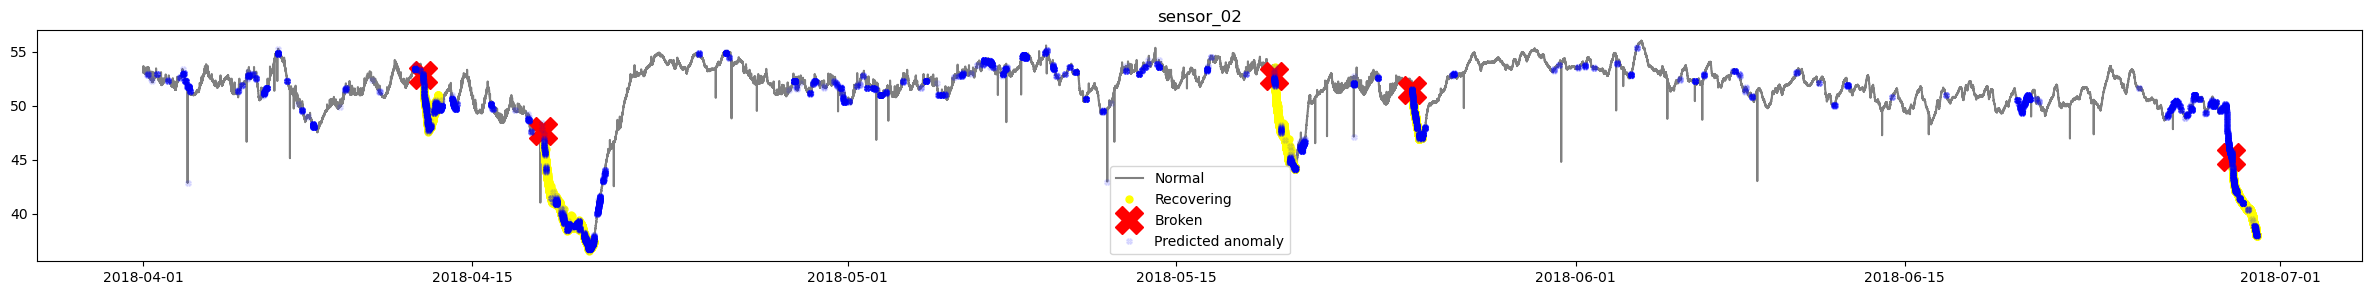

In [55]:
plot_sensor_anomalies('sensor_02',train_recovery_rows, train_broken_rows)